In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation as animation
import scipy as sp
import progressbar as pb
import time

%matplotlib inline

In [2]:
class proplyd:
    """
    The proplyd class acts as the environment that contains planetesimal
    tracers, plant embryos, protoplanets, disk components, and the host
    star. It contains references to the objects, methods to create new
    objects, and methods to govern the interactions between objects.
    """
    
    def __init__(self, disks={}, tracers={}, embryos={}, age=0,
                 extent=(0.1,100), mass=10, star_params={},
                 disk_params={}, tracer_params={}, embryo_params={}):
        self.disks = disks.copy()
        self.tracers = tracers.copy()
        self.history = {}
        self.embryos = embryos.copy()
        self.age = age
        self.extent = extent
        self.mass = mass
        self.star = star_params.copy()
#        self.disk_params = disk_params
#        self.tracer_params = tracer_params
#        self.embryo_params = embryo_params
        
        if len(disks) > 0:
            for disk in self.disks.keys():
                self.history[disk] = {}
#                self.disk_params[disk] = {}
                for param in self.disks[disk].keys():
                    self.history[disk][param] = np.array([self.disks[disk][param]])
#                    self.disk_params[disk][param] = disk_params[disk][params]
                    
        if len(tracers) > 0:
            for tracer in self.tracers.keys():
                self.history[tracer] = {}
#                self.tracer_params[tracer] = {}
                for param in self.tracers[tracer].keys():
                    self.history[tracer][param] = np.array([self.tracers[tracer][param]])
#                    self.tracer_params[tracer][param] = tracer_params[tracer][param]
                    
        if len(embryos) > 0:
            for embryo in self.embryos.keys():
                self.history[embryo] = {}
#                self.embryo_params[embryo] = {}
                for param in self.embryos[embryo].keys():
                    self.history[embryo][param] = np.array([self.embryos[embryo][param]])
#                    self.embryo_params[embryo][param] = embryo_params[embryo][param]
        
    def update_history(self):
        tracerkeys = np.array(list(self.tracers.keys()))
        embryokeys = np.array(list(self.embryos.keys()))
        historykeys = np.array(list(self.history.keys()))
        
        oldTracers = tracerkeys[np.where(np.isin(tracerkeys,historykeys))]
        oldEmbryos = embryokeys[np.where(np.isin(embryokeys,historykeys))]
        
        newTracers = False
        newEmbryos = False
        
        if len(tracerkeys)>0:
            newTracers = not np.isin(tracerkeys,historykeys).all()
            
        if len(embryokeys)>0:
            newEmbryos = not np.isin(embryokeys,historykeys).all()
        
        if newTracers:
            newTracerKey = np.where(np.isin(tracerkeys,historykeys,invert=True))
            for tracer in tracerkeys[newTracerKey]:
                self.history[tracer] = {}
                for param in self.tracers[tracer].keys():
                    self.history[tracer][param] = np.array([self.tracers[tracer][param]])
                    
        if newEmbryos:
            newEmbryoKey = np.where(np.isin(embryokeys,historykeys,invert=True))
            for embryo in embryokeys[newEmbryoKey]:
                self.history[embryo] = {}
                for param in self.embryos[embryo].keys():
                    self.history[embryo][param] = np.array([self.embryos[embryo][param]])
                    
        for tracer in oldTracers:
            for param in self.tracers[tracer].keys():
                self.history[tracer][param] = np.append(self.history[tracer][param],
                                                        np.array([self.tracers[tracer][param]]),
                                                        axis=0)
                
        for embryo in oldEmbryos:
            for param in self.embryos[embryo].keys():
                self.history[embryo][param] = np.append(self.history[embryo][param],
                                                        np.array([self.embryos[embryo][param]]),
                                                        axis=0)
    
    def update_age(self,dt):
        self.age += dt
        
    def self_interaction(self,tracer,*args):
        # method for self-interaction of planetesimal tracers
        # tracers MUST have sufficient parameters for computing coagulation
        # THIS WILL NOT WORK IF TRACERS ONLY HAVE R,V DATA
        pass
    
    def get_embryo_params(self,param):
        params = []
        for embryo in self.embryos.keys():
            params.append(self.embryos[embryo][param])
        return np.array(params)
    
    def get_tracer_params(self,param):
        params = []
        for tracer in self.tracers.keys():
            params.append(self.tracers[tracer][param])
        return np.array(params)

In [3]:
def leapfrog(ri,vi,rj,mj,dt,mstar=1):
    G = 6.67e-11
    Mstar = mstar*2e30
    r0 = ri.copy()
    v0 = vi.copy()
    r1 = r0 + 0.5*v0*dt
    dr = rj-r1
    v1 = v0 + (G*np.dot(mj*np.diag(1/np.linalg.norm(dr,axis=1)**3),dr)*dt).sum(axis=0) - G*Mstar*r1*dt/(np.linalg.norm(r1)**3)
    return r1 + 0.5*v1*dt, v1

In [4]:
 def initialize(N,Mstar=1,theta=None,return_params=False):
    """
    Initializes positions and velocities for N objects in Keplerian orbits about
    a star of mass Mstar.
    
    N is the number of objects to generate initial conditions for. initialize()
    returns the initial conditions as a Nx3x2 array.
    Mstar is the mass of the star, measured in solar masses
    theta is an array of parameters listing the bounds for parameter values.
    
    Parameters are drawn from uniform distributions bounded by the values in theta,
    or by a set of default parameters if none are provided. theta should be ordered
    as follows:
    amin, amax, imin, imax, emin, emax, wmin, wmax, fmin, fmax, Omin, Omax;
    an orbit is characterized by its semi-major axis, inclination, eccentricity,
    argument of periapse, initial true anomaly, and longitude of the ascending node.
    
    semi-major axis values should be given in au
    orientation angles should be given in radians
    eccentricities should be on [0,1)
    true anomaly bounds should be given in radians
    mass bounds should be given in Earth masses
    
    Positions are returned in meters
    Velocities are returned in meters per second
    """
    
    if theta is None:
        amin = 0.1
        amax = 20
        
        imin = np.radians(-15)
        imax = np.radians(15)
        
        emin = 0
        emax = 0.2
        
        wmin = 0
        wmax = 2*np.pi*(1-0.001)
        
        fmin = 0
        fmax = 2*np.pi*(1-0.001)
        
        Omin = 0
        Omax = 2*np.pi*(1-0.001)
        
        mmin = -1
        mmax = 2
        
        rhomin = 1e3
        rhomax = 6e3
    else:
        amin, amax, imin, imax, emin, emax, wmin, wmax, fmin, fmax, Omin, Omax, mmin, mmax, rhomin, rhomax = theta
        
    G = 6.67e-11 # SI units
    Msun = 2e30 # kg
    Mstar *= Msun
    AU = 1.496e11
    Mearth = 5.972e24
    
    avals = 10**np.random.uniform(amin,amax,N)*AU
    ivals = np.random.uniform(imin,imax,N)
    evals = np.random.uniform(emin,emax,N)
    wvals = np.random.uniform(wmin,wmax,N)
    fvals = np.random.uniform(fmin,fmax,N)
    Ovals = np.random.uniform(Omin,Omax,N)
    mvals = 10**np.random.uniform(mmin,mmax,N)*Mearth
    rhovals = np.random.uniform(rhomin,rhomax,N)
    
    rvals = avals*(1-evals**2)/(1+evals*np.cos(fvals))
    prefactors = rvals*np.sqrt(G*(Mstar+mvals)*(2/rvals - 1/avals))/(avals*(1-evals**2))
    
    initial_values = np.zeros((N,3,2))
    
    initial_values[:,0,0] = rvals*(np.cos(Ovals)*np.cos(wvals+fvals)-np.sin(Ovals)*np.sin(wvals+fvals)*np.cos(ivals))
    initial_values[:,1,0] = rvals*(np.sin(Ovals)*np.cos(wvals+fvals)+np.cos(Ovals)*np.sin(wvals+fvals)*np.cos(ivals))
    initial_values[:,2,0] = rvals*np.sin(wvals+fvals)*np.sin(ivals)
    
    initial_values[:,0,1] = -prefactors*(np.cos(Ovals)*(np.sin(wvals+fvals)+evals*np.sin(wvals))
                                        +np.sin(Ovals)*(np.cos(wvals+fvals)+evals*np.cos(wvals))*np.cos(ivals))
    initial_values[:,1,1] = prefactors*(-np.cos(Ovals)*(np.sin(wvals+fvals)+evals*np.sin(wvals))
                                       +np.cos(Ovals)*(np.cos(wvals+fvals)+evals*np.cos(wvals))*np.cos(ivals))
    initial_values[:,2,1] = prefactors*(np.cos(wvals+fvals)+evals*np.cos(wvals))*np.sin(ivals)
    
    initial_values = initial_values[np.argsort(avals),:,:]
    
    if return_params:
        params = np.vstack([avals,ivals,evals,wvals,fvals,Ovals,mvals,rhovals]).T[np.argsort(avals)]
        return initial_values, params
    else:
        return initial_values

In [41]:
def process_accretion(embryo,tracer,tracerID,dt,df,di):
    if tracer['Np'] == 0:
        pass
    else:
        Re = embryo['radius']
        Me = embryo['mass']
        vesc = np.sqrt(2*G*Me/Re)
        
        key = np.where(np.isin(tracerID,tracerkeys))[0]
        Rp = tracer_radii[key][0]
        Np = tracer['Np']
        r = params[key,0][0]
        cosi = np.linalg.norm(tracer['pos'][:2])/np.linalg.norm(tracer['pos'])
        dV = 0.001*r**3*cosi*np.radians(df)*np.radians(di)
        m = params[key,-1][0]*4*np.pi*Rp**3/3
        
        vrel = np.linalg.norm(embryo['vel']-tracer['vel'])
        Fgrav = 1 + (vesc/vrel)**2
        Ncol = np.floor(np.pi*(Re+Rp)**2*Np*vrel*Fgrav*dt/dV)
        
        if tracer['Np'] - Ncol <= 0 or tracer['mass'] - m*Ncol <= 0:
            embryo['radius'] *= (1+Np*m/embryo['mass'])**(1/3)
            embryo['mass'] += Np*m
            embryo['density'] = 3*embryo['mass']/(4*np.pi*embryo['radius']**3)
            tracer['Np'] = 0
            tracer['mass'] = 0
            tracer['pos'] = np.zeros(3)
            tracer['vel'] = np.zeros(3)
        else:
            embryo['radius'] *= (1+Ncol*m/embryo['mass'])**(1/3)
            embryo['mass'] += Ncol*m
            embryo['density'] = 3*embryo['mass']/(4*np.pi*embryo['radius']**3)
            tracer['mass'] = tracer['mass'] - m*Ncol
            tracer['Np'] = Np-Ncol



#    return {'Re':Re, 'Me':Me, 'vesc':vesc, 'Rp':Rp, 'Np':Np, 'r':r, 'cosi':cosi, 'dV':dV}
#    return Ncol

In [13]:
# Instantiate proplyd object
system = proplyd()

# Populate proplyd with Np planetesimal tracers and Ne embryos
Np = 200
Mstar = 1
theta = [0,1,
         np.radians(-5),np.radians(5),
         0,0.05,
         0,2*np.pi*0.99,
         0,2*np.pi*0.99,
         0,2*np.pi*0.99,
         -3,-2,
         3e3,8e3]
initial_vals, params = initialize(Np,theta=theta,return_params=True)


Ne = 5
thetap = [0,1,
         np.radians(-5),np.radians(5),
         0,0.05,
         0,2*np.pi*0.99,
         0,2*np.pi*0.99,
         0,2*np.pi*0.99,
         -1.5,-1,
         3e3,6e3]
embryos, embryo_params = initialize(Ne,theta=thetap,return_params=True)

system.star = {'mass':Mstar}
tracer_radii = 10**np.random.uniform(3,4.5,Np)
df = 0.2
di = 0.1

for i in range(Np):
    tracer = 'tracer{:d}'.format(i)
    system.tracers[tracer] = {}
    system.tracers[tracer]['pos'] = initial_vals[i,:,0]
    system.tracers[tracer]['vel'] = initial_vals[i,:,1]
    system.tracers[tracer]['mass'] = params[i,-2]
#    system.tracers[tracer]['density'] = params[i,-1]
#    system.tracers[tracer]['radii'] = tracer_radii[i]
#    system.tracers[tracer]['Reff'] = 0.5*params[i,0]*np.radians(df)
    system.tracers[tracer]['Np'] = np.floor(3*params[i,-2]/(4*np.pi*params[i,-1]*tracer_radii[i]**3))
    
for i in range(Ne):
    embryo = 'embryo{:d}'.format(i)
    system.embryos[embryo] = {}
    system.embryos[embryo]['pos'] = embryos[i,:,0]
    system.embryos[embryo]['vel'] = embryos[i,:,1]
    system.embryos[embryo]['mass'] = embryo_params[i,-2]
    system.embryos[embryo]['density'] = embryo_params[i,-1]
    system.embryos[embryo]['radius'] = (3*embryo_params[i,-2]/(4*np.pi*embryo_params[i,-1]))**(1/3)
    
system.update_history()

In [14]:
f = 1
dt = 24*3600*f
T = 100*3.154e7 # s
t = 0

tcol = []
tvals = [0]
#errors = [0]
collisions = []

G = 6.67e-11 # grav constant, SI units
Msun = 2e30


#E0 = 0.5*(masses*np.linalg.norm(velocities,axis=1)**2).sum() 
#E0 -= G*Mstar*Msun*(masses/np.linalg.norm(positions[0],axis=1)).sum()
#for i in range(N-1):
#    for j in range(i+1,N):
#        E0 -= G*masses[i]*masses[j]/np.linalg.norm(positions[0,i]-positions[0,j])

In [15]:
bar = pb.ProgressBar(max_value=T)
bar.start(max_value=T)
#eject_key = [[]]

while t < T:
    tracerkeys = np.array(list(system.tracers.keys()))
    embryokeys = np.array(list(system.embryos.keys()))
    positions = np.zeros((len(tracerkeys)+len(embryokeys),3))
    velocities = np.zeros((len(tracerkeys)+len(embryokeys),3))
    masses = np.zeros(len(tracerkeys)+len(embryokeys))
    separations = np.zeros((len(embryokeys),len(tracerkeys)))
    N = len(tracerkeys)
    M = len(embryokeys)
    
    for i in range(positions.shape[0]):
        if i < N:
            tracer = tracerkeys[i]
            positions[i] = system.tracers[tracer]['pos']
            velocities[i] = system.tracers[tracer]['vel']
            masses[i] = system.tracers[tracer]['mass']
        else:
            embryo = embryokeys[i-N]
            positions[i] = system.embryos[embryo]['pos']
            velocities[i] = system.embryos[embryo]['vel']
            masses[i] = system.embryos[embryo]['mass']
            for j in range(N):
                Reff = params[j,0]*df*0.5
                separations[i-N,j] = np.floor(np.linalg.norm(positions[i]-positions[j])/Reff)
            
    for i in range(positions.shape[0]):
        key = np.where(np.isin(np.arange(positions.shape[0]),i,invert=True))
        if i < N:
            tracer = tracerkeys[i]
            system.tracers[tracer]['pos'], system.tracers[tracer]['vel'] = leapfrog(positions[i], velocities[i],
                                                                                    positions[key,:], masses[key],
                                                                                    dt, Mstar)
        else:
            embryo = embryokeys[i-N]
            system.embryos[embryo]['pos'], system.embryos[embryo]['vel'] = leapfrog(positions[i], velocities[i],
                                                                                    positions[key,:], masses[key],
                                                                                    dt, Mstar)
            if np.isin(separations[i-N],0).any():
                tcol.append(t)
                collision_key = np.where(np.isin(separations[i-N],0))
                for j in collision_key[0]:
                    tracer = tracerkeys[j]
                    process_accretion(system.embryos[embryo],
                                      system.tracers[tracer],
                                      tracer,dt,df,di)
                    collisions.append([i-Np,j])

    bar.update(t)
    t += dt
    tvals.append(t)
    system.update_history()
    system.update_age(dt)

 99% (3153945600 of 3154000000.0) |##### | Elapsed Time: 4:15:24 ETA:   0:00:00

In [372]:
colkey = np.where(np.isin(tvals,tcol))[0]
Np = 100
ncol = []
Fb = 3
dv = []
cos = []
Nvals = []
for i in range(len(colkey)):
    embryoID = embryokeys[collisions[i][0]]
    tracerID = tracerkeys[collisions[i][1]]
    timeID = colkey[i]
    embryo = system.history[embryoID]
    tracer = system.history[tracerID]
    Re = embryo['radius'][timeID]
    Me = embryo['mass'][timeID]
    vesc = np.sqrt(2*G*Me/Re)
    
    Rp = tracer['radii'][timeID]
    N = tracer['Np'][timeID]
    r = params[np.where(np.isin(tracerID,tracerkeys))[0],0][0]
    cosi = np.linalg.norm(tracer['pos'][timeID][:2])/r
    dV = 0.001*r**3*cosi*np.radians(df)*np.radians(di)
    m = tracer['density'][timeID]*4*np.pi*Rp**3/3
    
    vrel = np.linalg.norm(embryo['vel'][timeID]-tracer['vel'][timeID])
    Fgrav = 1 + (vesc/vrel)**2
    Ncol = np.floor(np.pi*(Re+Rp)**2*N*vrel*Fgrav*Fb*dt/dV)
    ncol.append(Ncol)
    dv.append(dV)
    cos.append(cosi)
    Nvals.append(N)

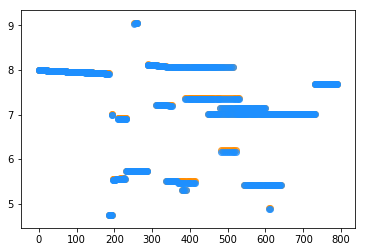

In [380]:
#plt.scatter(range(len(colkey)),np.log10(1+np.array(ncol)),color='darkred',alpha=0.7)
plt.scatter(range(len(colkey)),np.log10(1+np.array(Nvals)),color='darkorange',alpha=0.7)
plt.scatter(range(len(colkey)),np.log10(1+np.array(Nvals)-np.array(ncol)),color='dodgerblue',alpha=0.7)
plt.show()

In [370]:
len(ncol)

791

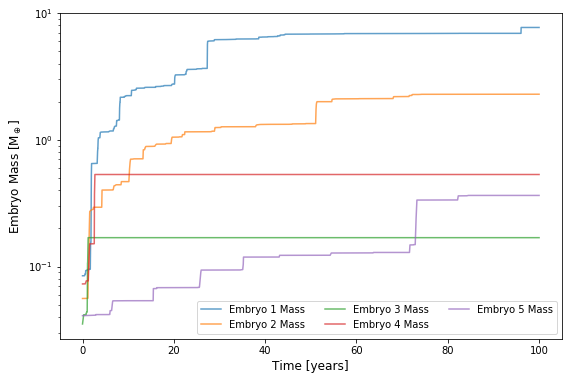

In [76]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [years]', fontsize=12)
ax.set_ylabel(r'Embryo Mass [M$_\oplus$]', fontsize=12)

for i in range(len(embryokeys[:])):
    embryo = embryokeys[i]
    ax.semilogy(np.array(tvals)/(365*24*3600),system.history[embryo]['mass']/5.927e24,alpha=0.7,label='Embryo {:d}'.format(i+1))
#    ax.semilogy(np.array(tvals)/(365*24*3600),system.history[embryo]['radius']/6e6,alpha=0.7,label='Embryo {:d}'.format(i+1))
#    ax.plot(np.array(tvals)/(365*24*3600),system.history[embryo]['density']/5.51e3,alpha=0.7,label='Embryo {:d}'.format(i+1))
    
ax.legend(ncol=2)
plt.show()
fig.savefig('Planet-Mass-Growth-200tracer.pdf')

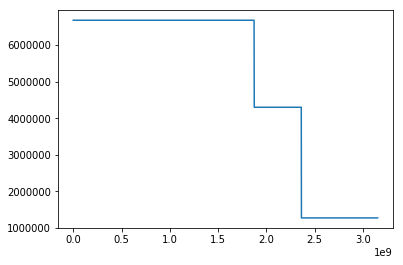

In [52]:
#plt.plot(tvals,tracer_masses[4])
plt.plot(tvals,tracer_Np[4])
plt.show()

In [47]:
np.where(tracer_masses[:,-1]<0)

(array([  3,   4,   5,   8,  10,  15,  18,  20,  24,  25,  28,  30,  32,
         40,  42,  43,  44,  47,  51,  52,  55,  56,  57,  58,  59,  62,
         63,  65,  70,  71,  73,  78,  79,  86,  89,  91,  92,  93,  98,
        101, 102, 104, 106, 107, 111, 119, 121, 126, 127, 130, 135, 143,
        144, 145, 148, 150, 162, 163, 167, 169, 175, 176, 177, 180, 189,
        192], dtype=int64),)

In [72]:
mp = tracer_densities*4*np.pi*tracer_radii**3/3
Mtot = np.zeros((len(mp),len(tracer_Np[0])))
for i in range(Mtot.shape[0]):
    Mtot[i] = mp[i]*tracer_Np[i]

dM = np.zeros(Mtot.shape)
for i in range(dM.shape[0]):
    dM[i] = Mtot[i]-tracer_masses[i]
    
len(dM[np.where(np.abs(dM)<1e12)])

1387

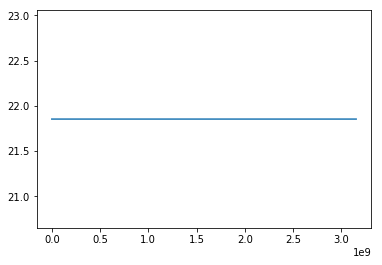

In [37]:
plt.plot(tvals,np.log10(1+system.history['tracer14']['mass']))
plt.show()

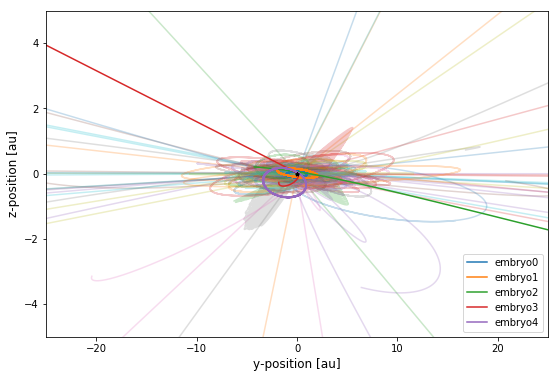

In [20]:
#k = int(np.floor(system.history['embryo0']['mass'].shape[0]/50))
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('y-position [au]', fontsize=12)
ax.set_ylabel('z-position [au]', fontsize=12)
ax.set_xlim(-25,25)
ax.set_ylim(-5,5)

tracers = system.tracers.keys()
embryos = system.embryos.keys()

for tracer in tracers:
    ax.plot(system.history[tracer]['pos'][:,1]/1.5e11,system.history[tracer]['pos'][:,2]/1.5e11,alpha=0.25)
for embryo in embryos:
    ax.plot(system.history[embryo]['pos'][:,1]/1.5e11,system.history[embryo]['pos'][:,2]/1.5e11,alpha=1,label=embryo)

ax.plot(0,0,marker='*',ms=4,color='k')
ax.legend()
plt.show()
fig.savefig('200body-5embryo-100-yr-yz.pdf')

In [456]:
distances = np.linalg.norm(system.history['embryo3']['pos'],axis=1)
key = np.where(distances==distances.min())
distances[key]/695.7e6

array([10.05487625])

In [473]:
distance = np.linalg.norm(system.history['embryo3']['pos'][int(k/2)]-system.history['embryo3']['pos'][k])
dt = tvals[k]-tvals[int(k/2)]
((distance-d2)*1.5e11/dt)/3e8

47858006.100099064

In [11]:
tvals = np.array(tvals)

In [45]:
tracer_positions = np.zeros((len(system.tracers),len(system.history['tracer0']['pos'][:,0]),3))
tracer_velocities = np.zeros((len(system.tracers),len(system.history['tracer0']['vel'][:,0]),3))
tracer_masses = np.zeros((len(system.tracers),len(system.history['tracer0']['mass'])))
tracer_Np = np.zeros((len(system.tracers),len(system.history['tracer0']['Np'])))
tracer_densities = np.zeros((len(system.tracers)))
#tracer_radii = np.zeros((len(system.tracers)))
tracer_Reff = np.zeros((len(system.tracers)))

embryo_positions = np.zeros((len(system.embryos),len(system.history['embryo0']['pos'][:,0]),3))
embryo_velocities = np.zeros((len(system.embryos),len(system.history['embryo0']['vel'][:,0]),3))
embryo_masses = np.zeros((len(system.embryos),len(system.history['embryo0']['mass'])))
embryo_radii = np.zeros((len(system.embryos),len(system.history['embryo0']['radius'])))
embryo_densities = np.zeros((len(system.embryos),len(system.history['embryo0']['density'])))


tracerkeys = np.array(list(system.tracers.keys()))
embryokeys = np.array(list(system.embryos.keys()))

for i in range(len(tracerkeys)+len(embryokeys)):
    if i < len(tracerkeys):
        tracer = tracerkeys[i]
        tracer_positions[i] = system.history[tracer]['pos']
        tracer_velocities[i] = system.history[tracer]['vel']
        tracer_masses[i] = system.history[tracer]['mass']
        tracer_Np[i] = system.history[tracer]['Np']
        tracer_densities[i] = params[i,-1]
        tracer_Reff[i] = 0.5*params[i,0]*df
    else:
        j = i-len(tracerkeys)
        embryo = embryokeys[j]
        embryo_positions[j] = system.history[embryo]['pos']
        embryo_velocities[j] = system.history[embryo]['vel']
        embryo_masses[j] = system.history[embryo]['mass']
        embryo_radii[j] = system.history[embryo]['radius']
        embryo_densities[j] = system.history[embryo]['density']

In [46]:
np.savez('100yr-200tracer-5embryo.npz',tracer_positions,tracer_velocities,tracer_masses,tracer_Np,
         tracer_densities,tracer_radii,tracer_Reff,embryo_positions,embryo_velocities,
         embryo_masses,embryo_densities,embryo_radii,tvals)

In [152]:
tracer_masses = system.get_tracer_params('mass')
tracer_densities = system.get_tracer_params('density')

n = 3*tracer_masses/(4*np.pi*tracer_densities*tracer_radii**3)

In [154]:
n.max()

79273087.19681044

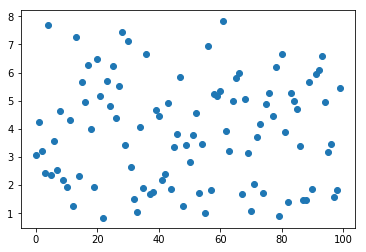

In [136]:
plt.scatter(range(N),np.log10(n))
plt.show()

In [ ]:
fig = plt.figure(figsize=(9,12))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [years]', fontsize=12)
ax.set_ylabel('Relative Distances', fontsize=12)

colors = [plt.cm.gist_earth(i) for i in 50*np.arange(5)]
embryokeys = list(system.embryos.keys())
tracerkeys = list(system.tracers.keys())

for i in range(len(colors)):
    embryo = embryokeys[i]
    

In [99]:
radii = np.linalg.norm(tracer_positions[:,-1,:],axis=1)
inclinations = np.linalg.norm(tracer_positions[:,-1,:2],axis=1)
dr = 10*6.371e6

dv = radii**2*dr*inclinations*np.radians(1)**2
reff = radii*np.radians(1)

In [111]:
radii.min()/1.5e11

0.16121505099531025

In [158]:
system.get_tracer_params('Np').max()

68364440.0

In [106]:
print('{:e}'.format(5e3*1e12))

5.000000e+15


In [131]:
radii[np.where(reff/1.5e11>0.01)].min()/1.5e11

1.2793534544152965

In [132]:
np.floor(3.9)

3.0

In [108]:
print('{:e}'.format(3*6e14/(4*np.pi*6e3)))

2.387324e+10


In [112]:
(3*6e12/(4*np.pi*6e3))**(1/3)

620.3504908993998

In [115]:
print('{:e}'.format(4*6e3*(1e5)**3*np.pi/3))

2.513274e+19


In [117]:
2.5e19/6e24

4.166666666666667e-06

In [118]:
np.log10(4)

0.6020599913279624

In [121]:
10**-5.3

5.011872336272725e-06

In [139]:
np.log10(4*np.pi*1e3*1e9*1e4/3/6e24)

-8.15606264108121

In [142]:
tracer_masses.min()/6e24

5.026679350401636e-06

In [143]:
tracer_densities.min()

1140.9992684464844

In [144]:
tracer_radii.min()

1001.4348551489819

In [145]:
3*tracer_masses.min()/(4*np.pi*tracer_densities.max()*tracer_radii.max()**3)

1.3126014394887064